In [20]:
import celerite
from celerite import terms
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
c = 2.99792458e8   # m/s

Construct the data:

In [21]:
data = pickle.load(open( "binary_data.p", "rb" ))
print len(data)

73


In [22]:
wave_lo = np.log(4680.)
wave_hi = np.log(4700.)
subset = []
#for i in range(len(data)):
for i in range(0,len(data),20):
    m = (data[i][0] > wave_lo) & (data[i][0] < wave_hi)
    x = np.copy(data[i][0][m])
    y = np.log(np.copy(data[i][1][m]))
    yerr = np.copy(data[i][2][m]/data[i][1][m])
    subset.append((x,y,yerr))

Set up the GP:

In [25]:
kernel = terms.RealTerm(np.log(0.04), -np.log(0.001), bounds=((np.log(.01*0.04),np.log(100.*0.04)),(None, None)))
gp = celerite.GP(kernel,
                 log_white_noise=-9.6,
                 fit_white_noise=True)

In [26]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_a', -3.2188758248682006),
             ('kernel:log_c', 6.9077552789821368),
             ('log_white_noise:value', -9.5999999999999996)])

Set up for marginalization of the scales:

In [27]:
nepoch = len(subset)
eye = np.eye(nepoch)
ndata_byepoch = [len(d[0]) for d in subset]
design = np.repeat(eye, ndata_byepoch, axis=0)
print design.shape
print design

(7996, 4)
[[ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]]


Set up the minimization:

In [28]:
def shift_and_flatten(xis, data):
    ndata = sum([len(d[0]) for d in data])
    ndata_byepoch = [len(d[0]) for d in data]
    n = 0
    x = np.empty(ndata)
    y = np.empty(ndata)
    yerr = np.empty(ndata)
    for i, d in enumerate(data):
        length = len(d[0])
        x[n:n+length] = d[0] - xis[i]
        y[n:n+length] = d[1]
        yerr[n:n+length] = d[2]
        n += length
    return x, y, yerr

In [29]:
def set_params(params):
    xis, gp_par = params[0:len(subset)], params[len(subset):]
    x, y, yerr = shift_and_flatten(xis, subset)
    inds = np.argsort(x)
    x = x[inds]
    y = y[inds]
    yerr = yerr[inds]
    A = np.copy(design)[inds,:]    
    gp.set_parameter_vector(gp_par)
    gp.compute(x, yerr)
    scales = np.linalg.solve(np.dot(A.T, gp.apply_inverse(A)), np.dot(A.T,gp.apply_inverse(y)))
    ndata_byepoch = [len(d[0]) for d in subset]
    y[np.argsort(inds)] -= np.repeat(scales, ndata_byepoch)
    return scales, xis, y

In [30]:
def nll(params):
    scales, xis, y = set_params(params)
    return -gp.log_likelihood(y) + 1./2. # * np.sum(xis**2)

In [31]:
def xi_to_v(xi):
    # translate ln(wavelength) Doppler shift to a velocity in m/s
    r = np.exp(2.*xi) # r = (c+v)/(c-v)
    return c * (r - 1.)/(r + 1.)
 
def v_to_xi(v):
    return np.log((1.+v/c)/(1.-v/c))/2.

In [32]:
#from scipy.io.idl import readsav
#print len(subset)
#data_dir = "/Users/mbedell/Documents/Research/HARPSTwins/Results/"
#pipeline = readsav(data_dir+'HIP14501_result.dat') 
#xis0 = np.empty(len(subset))
#rvs = np.empty(len(subset))
#for i,xi0 in enumerate(xis0):
#    rv0 = pipeline.rv[i*10]
#    rv0 *= 1.e3
#    xis0[i] = v_to_xi(rv0)
#    print rv0
#    print xis0[i]
#xis0 = v_to_xi(pipeline.rv)

xis0 = np.zeros(len(subset))

In [33]:
p0 = np.append(xis0, gp.get_parameter_vector())
print p0
bounds = [(-1e-4, 1e-4) for d in subset] + gp.get_parameter_bounds()
print bounds

scales, xis, y = set_params(p0)

[ 0.          0.          0.          0.         -3.21887582  6.90775528
 -9.6       ]
[(-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-0.0001, 0.0001), (-7.8240460108562919, 1.3862943611198906), (None, None), (None, None)]


In [34]:
soln = minimize(nll, p0, bounds=bounds, method='L-BFGS-B')
scales, xis, y = set_params(soln.x)

In [35]:
print soln
print xi_to_v(xis)

      fun: -23760.91250017146
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.33141049e+09,   6.71294713e+08,  -1.41231043e+09,
         9.96396757e+08,   1.20186451e+02,   1.15351213e+02,
         6.95620838e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 232
      nit: 8
   status: 0
  success: True
        x: array([ -5.01296165e-07,  -5.14315896e-07,  -5.21575118e-07,
        -5.13323790e-07,  -3.21681328e+00,   8.61479499e+00,
        -1.01193125e+01])
[-150.2848094  -154.18802668 -156.36428668 -153.89060081]


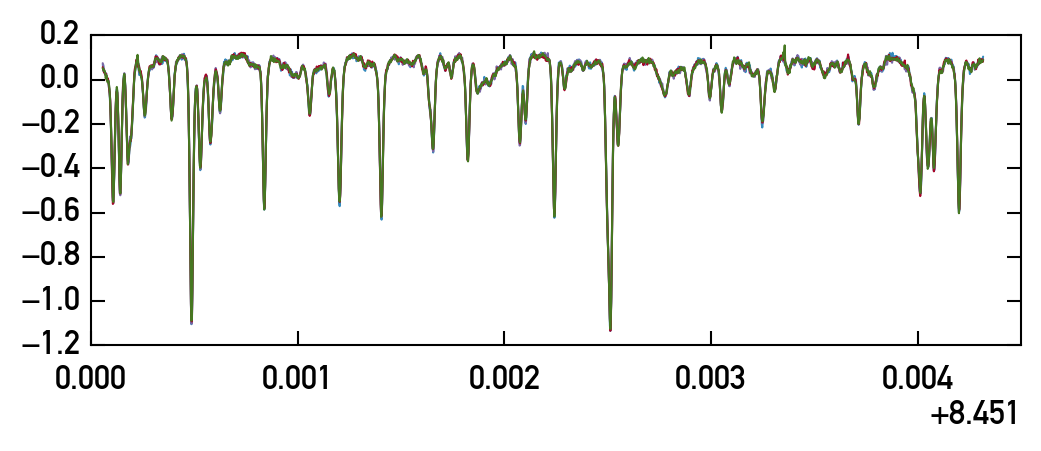

In [36]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,d in enumerate(subset):
    ax.plot(d[0] - xis[i],d[1] - scales[i])

Check out the prediction:

In [37]:
def prediction(params):
    scales, xis, y = set_params(params)
    result_flat = gp.predict(y, return_cov=False)
    x, _, _ = shift_and_flatten(xis, subset)
    inds = np.argsort(x)
    result_sorted = result_flat[np.argsort(inds)]
    result = []
    n = 0
    for i,d in enumerate(subset):
        length = len(d[0])
        result.append(result_sorted[n:n+length] + scales[i])
        n += length
    return result

In [38]:
mu = prediction(soln.x)

In [39]:
print mu

[array([ 9.77001953,  9.76680827,  9.75397019, ...,  9.79560578,
        9.79690799,  9.80167519]), array([ 9.85557032,  9.85211225,  9.83920918, ...,  9.88142419,
        9.88229074,  9.88684998]), array([ 10.37204754,  10.36841285,  10.35596665, ...,  10.39819017,
        10.39865247,  10.40347017]), array([ 10.3807903 ,  10.3773726 ,  10.36448768, ...,  10.40663953,
        10.40757423,  10.41214178])]


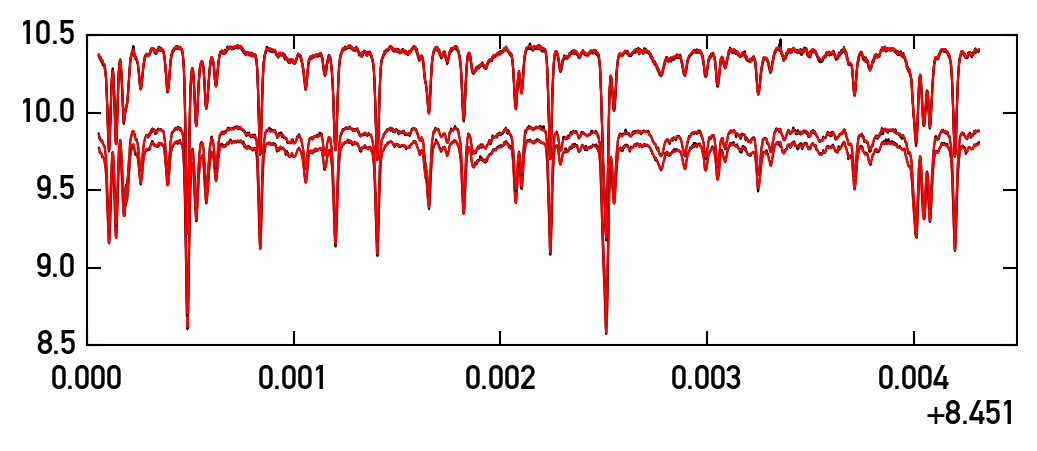

In [40]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,d in enumerate(subset):
    ax.plot(d[0], d[1], color='black')
    ax.plot(d[0], mu[i], color='red')

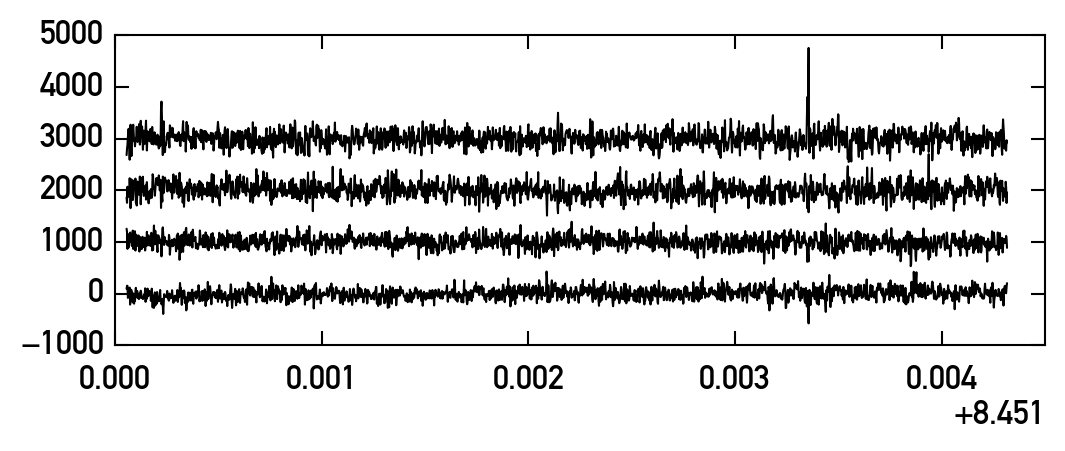

In [41]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
for i,d in enumerate(subset):
    ax.plot(d[0], (np.exp(d[1]) - np.exp(mu[i])) + 1000*i, color='black')
